In [107]:
import numpy as np
import matplotlib.pyplot as plt

# Queueing simulation with antithetic draws

In [163]:
def exponential_rng(lam, u):  
    """ Generates exponential random number.
    
    Keywords:
        lam (float): the rate parameter, the inverse expectation of the distribution.
        u (float): Uniform random number.
    
    Returns:
        exponential random number with given rate.
    """
    return -np.log(u) / lam

In [164]:
class Event:
    """ Generic event.
    
    Attributes:
        time (float): Event time.
    """
    def __init__(self, event_type,time):
        self.time = time
        type_map = {
            0: "SIMULATION_START",
            1: "GENERATION",
            2: "ARRIVAL",
            3: "DEPARTURE",
            4: "SIMULATION_END",
            }
        if event_type in type_map:
            self.type = type_map[event_type]
                
class Generation(Event):
    """ Generation event.
    
    Attributes:
        time (float): Event time.
    """
    def __init__(self, time):
        super().__init__(time)
        
class Arrival(Event):
    """ Arrival event.
    
    Attributes:
        time (float): Event time.
    """
    def __init__(self, time):
        super().__init__(time)
        
class Departure(Event):
    """ Departure event.
    
    Attributes:
        time (float): Event time.
    """
    def __init__(self, time):
        super().__init__(time)
        
class Termination(Event):
    """ Termination event.
    
    Attributes:
        time (float): Event time.
    """
    def __init__(self, time):
        super().__init__(time)

In [165]:
class Scenario:
    """ Road scenario
    
    Attributes:
        demand duration (float): Duration of vehicle generation.
        t0 (float): Free-flow travel time.
        lam (float): Entry rate.
        mu (float): Service rate.
    """
    
    def __init__(self, 
                 demand_duration=50.0,
                 t0=1.0,
                 lam=1.0,
                 mu=1.0,
                ):
        self.demand_duration = demand_duration
        self.t0 = t0
        self.lam = lam
        self.mu = mu

In [189]:
def simulate(scenario, u):
    """ Implements the simulation procedure.
    
    Keywords:
        scenario (Scenario): Road scenario.
        u (array): 3 x N array of uniform random numbers, N must be sufficiently large.
    
    Returns:
        times (list): Event times. 
        queues (list): Queue length over time. 
    """
    
    ###
    
    current_time = 0
    queue = 0
    events = []
    times = []
    queues = []
    total_service_time = 0  # Initialize total service time
    departures = 0  # Initialize number of departures

    # Function to add events and keep the list sorted by event time
    def schedule_event(event):
        events.append(event)
        events.sort(key=lambda e: e.time)
    
    # Initialize with simulation start
    schedule_event(Event(0, current_time))
    i=0
    while events:
        # Get the next event
        event = events.pop(0)
        current_time = event.time
        times.append(current_time)
        queues.append(queue)
        i+=1
        
        if event.type == "SIMULATION_START":
            # Schedule first generation event and simulation end
            schedule_event(Event(1, current_time))  ##Genaration
            schedule_event(Event(4, scenario.demand_duration)) ##SimEnd
        
        elif event.type == "GENERATION":
            # Generate a vehicle and schedule next generation if within demand duration
            if current_time <= scenario.demand_duration:
                schedule_event(Event(1, current_time+exponential_rng(scenario.lam,u=u[0][i]) )) ##Next generation
                schedule_event(Event(2, current_time+ np.random.uniform(0,scenario.t0) )) ##Arrive
                
                
        elif event.type == "ARRIVAL":
            # Vehicle arrives at the queue
            queue += 1
            if queue == 1:  # If the queue was empty, schedule departure
                service_start_time = current_time 
                schedule_event(Event(3, current_time+exponential_rng(scenario.lam,u=u[1][i]) ))
        
        elif event.type == "DEPARTURE":
            # Vehicle leaves the queue
            service_end_time = current_time  # Capture the service end time
            service_time = service_end_time - service_start_time  # Calculate service time for this departure
            total_service_time += service_time  # Add to total service time
            departures += 1  # Increment departures
            queue -= 1
            if queue > 0:  # If there are more vehicles, schedule next departure
                service_start_time = current_time 
                schedule_event(Event(3,current_time + current_time+exponential_rng(scenario.lam,u=u[2][i]) ))
            else:
                times.append(current_time)
                queues.append(queue)
    
        elif event.type == "SIMULATION_END":
            break  # End simulation
        
    if departures > 0:
        service_time_mean = total_service_time / departures
    else:
        service_time_mean = 0

    return times, queues, service_time_mean

In [190]:
def moving_mean_var(new_data, old_mean, old_var, k):
    """ Calculates moving sample mean and variance at time k.
    
    Keywords:
        new_data (float): new data point arriving at time k.
        old_mean (float): previous sample mean.
        old_var (float): previous sample variance.
        k (int): time index (starting from 1)
    
    Returns:
        new_mean (float): updated sample mean.
        new_var (float): updated sample variance.
    """
    if k == 0:
        # If this is the first data point, initialize mean and variance
        new_mean = new_data
        new_var = 0  # Variance is 0 as there's only one data point
    else:
        # Update the mean according to the slide formula
        new_mean = old_mean + (new_data - old_mean) / (k+1)
        # Update the variance according to the slide formula
        new_var = (1 - 1/k) * old_var + (k+1) * (new_mean - old_mean)**2

    return new_mean, new_var

### Independent runs

In [191]:
#Requested precision for the estimation of the average maximum queue length. 
#Empirically calculated such that approximately 100 simulation runs are necessary.
precision = 0.5

max_queue_mean = 0
max_queue_var = 0
max_queue_all = []
max_queue_mean_all = []
max_queue_var_all = []
run = 0

scenario = Scenario()
np.random.seed(4712)

#Main loop
while True:
    run += 1
    u = np.random.rand(3,1000)
    #Run simulation
    _, queues,_ = simulate(scenario, u)
    max_queue = max(queues)
    
    #Collect statistics
    max_queue_mean, max_queue_var = moving_mean_var(max_queue, max_queue_mean, max_queue_var, run)
    max_queue_all.append(max_queue)
    max_queue_mean_all.append(max_queue_mean)
    max_queue_var_all.append(max_queue_var)
    
    #Check if necessary precision reached
    if run >= 100 and np.sqrt(max_queue_var / run) < precision:
        break
        
sd_independent = np.sqrt(max_queue_var_all)
sd_independent

array([39.59797975, 29.30870178, 24.01388487, 21.59398064, 19.61631974,
       17.94303154, 17.02728902, 16.36306817, 15.58524944, 14.78697215,
       14.71831471, 14.72613236, 14.14990389, 13.76434317, 13.30898819,
       12.89607784, 12.5135221 , 12.21493669, 11.89250095, 12.29595365,
       12.12310591, 11.98335473, 11.79835103, 11.59985632, 11.65484383,
       11.64650272, 11.46440315, 11.26658602, 11.07321507, 11.04214799,
       10.88632614, 10.75105703, 10.62284895, 10.47060712, 10.34269929,
       10.2456319 , 10.15554701, 10.20359546, 10.62046283, 10.49895465,
       10.38148647, 10.27463412, 10.22296362, 10.1066035 ,  9.99661779,
        9.89468129,  9.79108003,  9.69066631,  9.62405574,  9.53992642,
        9.53868048,  9.50082114,  9.43298108,  9.34793231,  9.26435355,
        9.18389814,  9.16906145,  9.26491721,  9.30613976,  9.27612247,
        9.20650047,  9.13201802,  9.13305526,  9.0644063 ,  9.1118407 ,
        9.04401519,  9.01997588,  8.95391726,  8.91980605,  8.98

### Antithetic runs

In [192]:
precision = 0.5

max_queue_mean = 0
max_queue_var = 0
max_queue_all = []
max_queue_mean_all = []
max_queue_var_all = []
run = 0

scenario = Scenario()
np.random.seed(4712)
#Main loop
while True:
    run += 1
    u = np.random.rand(3,1000)
    #Run simulation
    _, queues,_ = simulate(scenario, u)
    _, queues_antithetic,_ = simulate(scenario, 1-u)
    max_queue = (max(queues)+max(queues_antithetic))/2
    
    
    #Collect statistics
    max_queue_mean, max_queue_var = moving_mean_var(max_queue, max_queue_mean, max_queue_var, run)
    max_queue_all.append(max_queue)
    max_queue_mean_all.append(max_queue_mean)
    max_queue_var_all.append(max_queue_var)
    
    #Check if necessary precision reached
    if run >= 100 and np.sqrt(max_queue_var / run) < precision:
        break
        
###

sd_antithetic = np.sqrt(max_queue_var_all)
sd_antithetic

array([35.00178567, 28.72426384, 25.00333311, 21.72728699, 19.50897229,
       17.85823806, 16.54201901, 15.47399252, 14.72346955, 14.18241549,
       13.52242806, 12.98137226, 12.85512041, 12.39642806, 11.97736581,
       11.59883995, 11.41754326, 11.13861362, 10.86262908, 10.59351778,
       10.34062723, 10.10503142,  9.88335502,  9.69308173,  9.57777877,
        9.41043399,  9.23866029,  9.08047627,  8.96879969,  8.827864  ,
        8.75413209,  8.62362747,  8.49577855,  8.40530545,  8.28466742,
        8.18450433,  8.13160772,  8.03133623,  7.99197314,  7.91328768,
        7.81687363,  7.78363633,  7.75857978,  7.67122723,  7.58597263,
        7.53766368,  7.49413926,  7.43708018,  7.37870626,  7.39122426,
        7.31947134,  7.24924299,  7.2113751 ,  7.17227875,  7.11126781,
        7.05440059,  7.00896065,  6.95375893,  6.89699742,  6.85740794,
        6.80178007,  6.74873639,  6.80596654,  6.75260811,  6.7034982 ,
        6.69811668,  6.64978612,  6.61594892,  6.57145783,  6.55

Plot the standard deviation of maximum queue length.

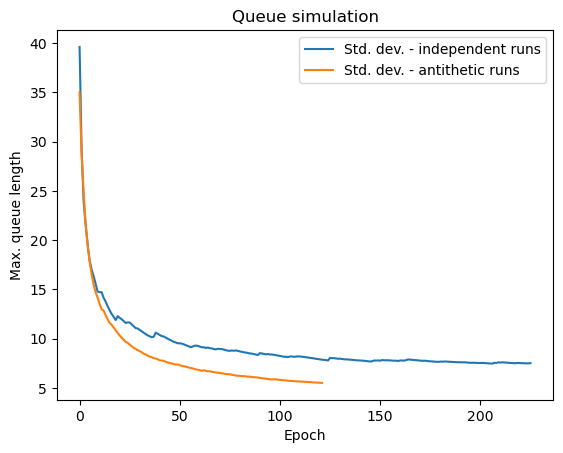

In [193]:
fig = plt.figure()
ax = plt.subplot(1,1,1)

ax.plot(sd_independent, label='Std. dev. - independent runs')
ax.plot(sd_antithetic, label='Std. dev. - antithetic runs')
ax.set(title='Queue simulation',
       xlabel='Epoch',
       ylabel='Max. queue length')
ax.legend()
fig.savefig('figure_antithetic.pdf', dpi=300)
plt.show()

# Queueing simulation with control variates

In [198]:
def controlled_mean(x, y, mu):
    """ Calculates the controlled mean.
    
    Keywords:
        x (array): Data.
        y (array): Control data.
        mu (float): Scalar expectation of the control data.
    
    Returns:
        avg (float): Controlled mean of the data.
        var (float): Variance of the controlled mean.
        z (array): Optimal linear combination of the data and the control data. 
    """

    
    # Compute sample variances and covariance
    var_y = np.var(y)
    cov_xy = np.cov(x, y)[0, 1]
    
    # Calculate the coefficient 'a_hat' for the control variate
    a_hat = cov_xy / var_y
    
    # Calculate the new controlled variable Z
    z = x - a_hat * (y - mu)
    
    # Calculate the controlled mean of X
    avg = np.mean(z)
    var = np.var(z)
    
    return avg, var, z

In [213]:
#Requested precision for the estimation of the average maximum queue length. 
#Empirically calculated such that approximately 100 simulation runs are necessary.
precision = 0.5

max_queue_mean = 0
max_queue_var = 0
max_queue_all = []
max_queue_mean_controlled_all = []
max_queue_var_controlled_all = []
service_time_mean_all = []
run = 0

scenario = Scenario()
np.random.seed(4712)
#Main loop
while True:
    run += 1
    u = np.random.rand(3,1000)
    #Run simulation
    _, queues,service_time_mean = simulate(scenario, u)
    max_queue = max(queues)
    max_queue_all.append(max_queue)
    service_time_mean_all.append(service_time_mean)
    #Collect statistics
    if run >1:
        max_queue_mean, max_queue_var,_ = controlled_mean(x=np.array(max_queue_all),y=np.array(service_time_mean_all), mu=scenario.mu)
        max_queue_mean_controlled_all.append(max_queue_mean)
        max_queue_var_controlled_all.append(max_queue_var)
    
    #Check if necessary precision reached
    if run >= 100 and np.sqrt(max_queue_var / run) < precision:
        break

sd_control = np.sqrt(max_queue_var_controlled_all)
sd_control

array([6.5       , 7.5254243 , 6.90521638, 6.18246386, 5.87416755,
       5.64393487, 5.58246784, 6.29083433, 6.24292333, 6.59241519,
       7.09478322, 6.92642737, 6.75265124, 6.64590742, 6.45601259,
       6.27322171, 6.1321979 , 6.00372568, 6.88644767, 7.03612686,
       7.22295129, 7.0985515 , 6.9908198 , 7.33320399, 7.45235733,
       7.41479073, 7.28263121, 7.15626288, 7.20446591, 7.13302654,
       7.05515294, 7.02837826, 6.94238562, 6.86528563, 6.86399771,
       6.81672803, 6.97056705, 7.66868249, 7.57470096, 7.48544184,
       7.41535649, 7.51922885, 7.4354645 , 7.36749611, 7.30334048,
       7.22531321, 7.15001352, 7.13648034, 7.07573537, 7.15364581,
       7.1528281 , 7.11319342, 7.04920162, 6.99191707, 6.93029842,
       6.95213589, 7.04886819, 7.1421199 , 7.12884425, 7.08866163,
       7.0353501 , 7.08259291, 7.03091267, 7.08415852, 7.03060526,
       6.99545417, 6.9459862 , 6.91559301, 7.06376439, 7.09056617,
       7.15784981, 7.11501927, 7.07123224, 7.02621862, 7.03778

Information on correlation

In [214]:
np.corrcoef(service_time_mean_all, max_queue_all)

array([[1.        , 0.14360824],
       [0.14360824, 1.        ]])

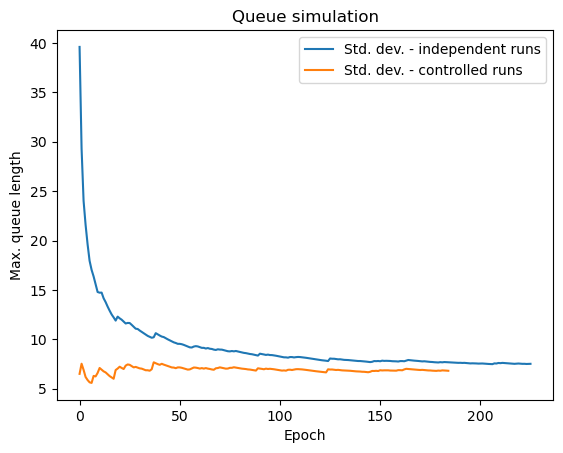

In [215]:
fig = plt.figure()
ax = plt.subplot(1,1,1)

ax.plot(sd_independent, label='Std. dev. - independent runs')
ax.plot(sd_control, label='Std. dev. - controlled runs')
ax.set(title='Queue simulation',
       xlabel='Epoch',
       ylabel='Max. queue length')
ax.legend()
fig.savefig('figure_control_variates.pdf', dpi=300)
plt.show()